In [11]:
import pandas as pd
from scipy.io import loadmat
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Load Data from prevous work

In [82]:
Adj = loadmat('Adj.mat')
patients = loadmat('patientNums.mat')

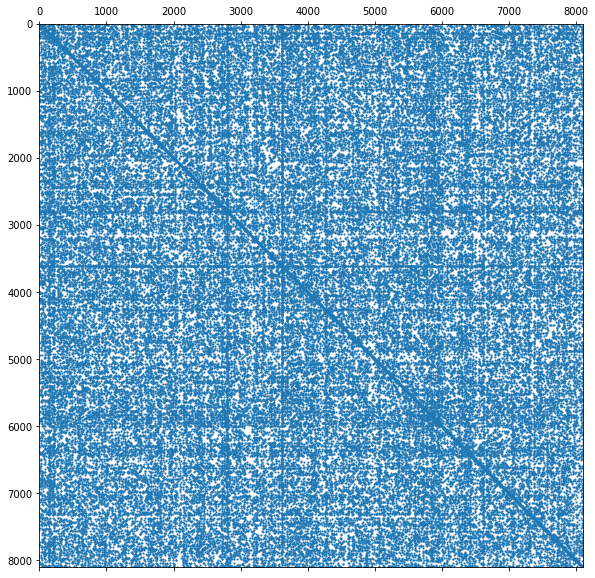

In [17]:
fig = plt.figure(figsize = (10,10))
plt.spy(Adj['Adj'], markersize = 1, precision = 10)

#### Lets work with a 100 doctors for now

In [422]:
docNum = 100

In [423]:
adj  = Adj['Adj'][:docNum,:docNum]
adj = adj.todense()

###  remove self loops

In [424]:
np.fill_diagonal(adj, 0)

#### Load number of patients

In [425]:
mean_patients = patients['MP']

In [426]:
docs = np.arange(docNum).reshape(-1,1)
print(docs.shape)

(100, 1)


### Clean out doctors that are disconnected from the network

In [427]:
hasOutDegree = np.any(adj, axis=0)
hasInDegree = np.any(adj, axis=1)
not_disconnected = np.logical_and(hasOutDegree.transpose(),hasInDegree).reshape(-1,1)
print(not_disconnected.shape)
docs = docs[not_disconnected]
print(docs)

(100, 1)
[ 1  2  3  6  7 13 16 17 19 21 22 24 25 28 32 34 35 38 39 41 42 43 45 49
 50 51 52 53 56 57 58 60 62 63 65 68 69 72 73 75 78 79 80 82 83 85 87 94
 96 98]


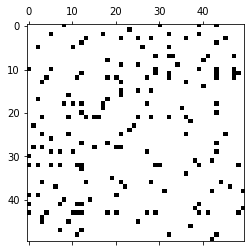

In [428]:
adj = adj[docs, :]
adj = adj[:,docs]
plt.spy(adj)

### Select doctors that are removed

In [429]:
failed = np.random.choice(docs, 2)
print(failed)

[49 87]


### Capacity (relative to average)

In [430]:
C = 0.1

### Doctor Properties

In [431]:
DocPatients = mean_patients[docs].astype(int).squeeze()
DocCapacity = DocPatients*(1+C)

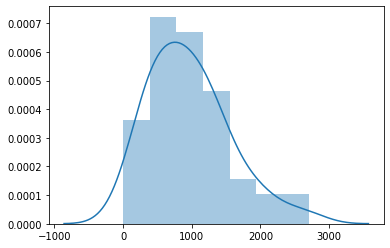

In [432]:
sns.distplot(DocPatients)

### Reindex doctors

In [433]:
doc_for_sim = np.arange(docs.shape[0])
print("original failed: ", failed)
doc2sim = {Id:newID for Id, newID in zip(docs, doc_for_sim)}
if not any(item in docs for item in failed):
    print("one of the failed doctors is disconnected. Case will be covered in the future. Failed = ", 
          failed, ", connected = ", docs)
print(doc2sim)
failed = [doc2sim[f] for f in failed]
print(doc_for_sim, failed)

original failed:  [49 87]
{1: 0, 2: 1, 3: 2, 6: 3, 7: 4, 13: 5, 16: 6, 17: 7, 19: 8, 21: 9, 22: 10, 24: 11, 25: 12, 28: 13, 32: 14, 34: 15, 35: 16, 38: 17, 39: 18, 41: 19, 42: 20, 43: 21, 45: 22, 49: 23, 50: 24, 51: 25, 52: 26, 53: 27, 56: 28, 57: 29, 58: 30, 60: 31, 62: 32, 63: 33, 65: 34, 68: 35, 69: 36, 72: 37, 73: 38, 75: 39, 78: 40, 79: 41, 80: 42, 82: 43, 83: 44, 85: 45, 87: 46, 94: 47, 96: 48, 98: 49}
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49] [23, 46]


### Create a vector of patient locations

In [434]:
patient_locations = np.hstack(np.array([i*np.ones(NPats) 
                                        for i, NPats in zip(failed,
                                                            DocPatients[failed])])).astype(int)
print(len(patient_locations))

2133


### Patient Status and number of displacements per patient (1 = searching, 0 = found doctor)

In [435]:
patient_status = np.ones(patient_locations.shape, dtype=bool)
patient_displacements = np.zeros(patient_locations.shape)

### Create probability vectors for the next step of each patient

In [436]:
prob_weights = adj[patient_locations]
prob_weights.shape

(2133, 50)

### Randomly select new destination

In [455]:
def vectorized(prob_matrix, items):
    ''''
    Given a probability matrix and a list of items it selects on item based on the column of probability matrix
    '''

    s = prob_matrix.cumsum(axis=0)
    print(s)
    r = np.random.rand(prob_matrix.shape[1])
    print(r)
    k = (s < r).sum(axis=0)
    print(k)
    return items[k]

### Assign target node for the step of each patient

In [438]:
targets = vectorized(prob_weights.transpose(), doc_for_sim)

[[0. 0. 0. ... 0. 0. 0.]
 [4. 4. 4. ... 0. 0. 0.]
 [4. 4. 4. ... 0. 0. 0.]
 ...
 [7. 7. 7. ... 8. 8. 8.]
 [7. 7. 7. ... 8. 8. 8.]
 [7. 7. 7. ... 8. 8. 8.]]
[0.45511137 0.01140147 0.932686   ... 0.41492716 0.68698796 0.53387772]
[[ 1  1  1 ... 37 37 37]]


### Teleportation probability is alpha

In [439]:
alpha = 0.15

### Some patients teleport instead of following the network

In [440]:
teleport = np.random.random(targets.shape)<alpha
print(teleport)

[[ True False False ... False False False]]


In [441]:
targets[teleport] = np.random.choice(doc_for_sim)

#### Final targets are distributed like so:

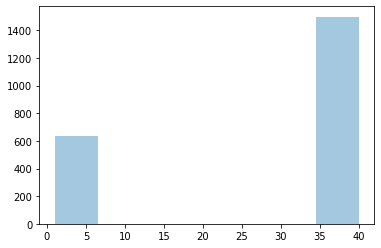

In [442]:
sns.distplot(targets, kde=False)

### Each doctor would receive this number of patients

In [443]:
incoming, _ = np.histogram(targets, bins=np.arange(len(doc_for_sim)+1))

### Update displacements per patient

In [444]:
patient_displacements+=1

### The incoming patients are evaluated against the available capacity of each doctor

In [445]:
intake = (DocCapacity-DocPatients).squeeze()
print(intake)
intake[intake<0] = 0
print(incoming)
DocExcess = incoming-intake
print(DocExcess)
Absorbed = (DocExcess<=0)
print(Absorbed)
DocExcess[Absorbed] = 0
print(DocExcess)

[ 95.4 144.1  35.2  48.9  30.5  39.2   8.  110.5  83.1 129.   21.9  86.9
 132.8 167.5  51.9 271.2  80.5 168.4 237.7  69.2 199.8  78.3  25.9  74.2
 202.9 182.5  46.8 127.7  98.1  70.5  61.9  28.2  72.2  45.5 107.8 120.6
 120.8  44.5   0.  147.7  73.1  82.2 111.2 114.5 103.9 141.8 139.1  42.5
  40.2  93.4]
[   0  634    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0 1166    0    0  333    0
    0    0    0    0    0    0    0    0]
[ -95.4  489.9  -35.2  -48.9  -30.5  -39.2   -8.  -110.5  -83.1 -129.
  -21.9  -86.9 -132.8 -167.5  -51.9 -271.2  -80.5 -168.4 -237.7  -69.2
 -199.8  -78.3  -25.9  -74.2 -202.9 -182.5  -46.8 -127.7  -98.1  -70.5
  -61.9  -28.2  -72.2  -45.5 -107.8 -120.6 -120.8 1121.5    0.  -147.7
  259.9  -82.2 -111.2 -114.5 -103.9 -141.8 -139.1  -42.5  -40.2  -93.4]
[ True False  True  True  True  True  True  True  True  True  True  True
  True  Tru

### Patients that landed at doctors that can absorb all can stop searching

In [446]:
patient_status[np.in1d(targets, doc_for_sim[Absorbed])] = 0

In [453]:
patient_status.sum()/len(patient_status)

1.0

### Update the number of patients each doctor has in his/her care

In [452]:
DocPatients[Absorbed] =  DocPatients[Absorbed] + intake[Absorbed]
DocPatients[np.logical_not(Absorbed)] = DocCapacity[np.logical_not(Absorbed)]

### To do

1) Randomly select patients that are taken care of by doctor when a batch arrives at a location that is overloaded

2) Update all patient measures

3) Put all the above in a function that increases time by 1